In [143]:
import json
import numpy as np
import matplotlib.pyplot as plt


from astropy.io import fits
from scipy.stats import trim_mean

In [144]:
with open("sci_files_object_mapping.json", "r") as f:
    sci_files_object_mapping = json.load(f)

object_names = list(sci_files_object_mapping.keys())

In [145]:
name = object_names[0].replace(" ", "").lower()
filename = f"{name}_pca_combined_spectra_ext_3D_linefit.fits"

with fits.open(filename) as hdulist:
    hdulist.info()

Filename: ero-qpe2_pca_combined_spectra_ext_3D_linefit.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     216   ()      
  1  RESTWAVE      1 ImageHDU        12   (3422,)   float64   
  2  FITSPEC       1 ImageHDU        15   (33, 49, 3422)   float32   
  3  VAR           1 ImageHDU        15   (33, 49, 3422)   float32   
  4  FITCONT       1 ImageHDU        15   (33, 49, 3422)   float32   
  5  STELLAR       1 ImageHDU        15   (33, 49, 3422)   float32   
  6  MODEL         1 ImageHDU        15   (33, 49, 3422)   float32   
  7  SOLUTION      1 ImageHDU        16   (33, 49, 30)   float64   
  8  RED_CHI       1 ImageHDU        15   (33, 49)   float64   
  9  INIGUESS      1 ImageHDU        14   (30,)   float64   
 10  FLUX_M        1 ImageHDU        16   (33, 49, 10)   float64   
 11  FLUX_D        1 ImageHDU        16   (33, 49, 10)   float64   
 12  EQW_M         1 ImageHDU        16   (33, 49, 10)   float64   
 13  EQW_D       

In [146]:
nii6583_index = 7
ha_index = 6
oiii5007_index = 2
hb_index = 0

In [173]:
bias = 1e-8
data = {}
for object_name in object_names:
    data[object_name] = {}
    name = object_name.replace(" ", "").lower()
    filename = f"{name}_pca_combined_spectra_ext_3D_rscorrect_dq_linefit.fits"
    flux_model = fits.getdata(filename, "FLUX_M")
    data[object_name]["nii"] = flux_model[nii6583_index] + bias
    data[object_name]["ha"] = flux_model[ha_index] + bias
    data[object_name]["oiii"] = flux_model[oiii5007_index] + bias
    data[object_name]["hb"] = flux_model[hb_index] + bias
    data[object_name]["niiha"] = np.log10(
        data[object_name]["nii"] / data[object_name]["ha"]
    )
    data[object_name]["oiiihb"] = np.log10(
        data[object_name]["oiii"] / data[object_name]["hb"]
    )

    eqw_model = fits.getdata(filename, "EQW_M")
    data[object_name]["WHa"] = eqw_model[ha_index] * -1

/tmp/ipykernel_1433323/943179301.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("Pastel2", len(object_names))


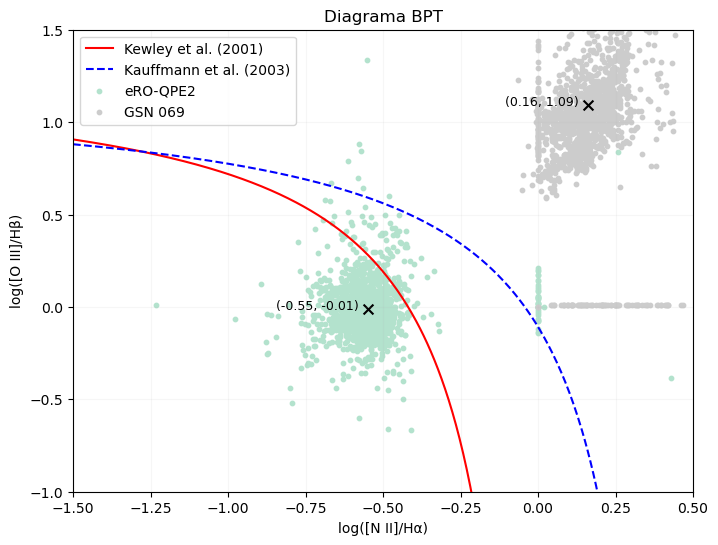

In [174]:
plt.figure(figsize=(8, 6))

x_kewley = np.linspace(-1.5, 0.045, 400)
y_kewley = 0.61 / (x_kewley - 0.05) + 1.3
x_kauffmann = np.linspace(-1.5, 0.3, 400)
y_kauffmann = 0.61 / (x_kauffmann - 0.47) + 1.19

plt.plot(x_kewley, y_kewley, label="Kewley et al. (2001)", color="red")
plt.plot(
    x_kauffmann,
    y_kauffmann,
    label="Kauffmann et al. (2003)",
    color="blue",
    linestyle="--",
)

cmap = plt.cm.get_cmap("Pastel2", len(object_names))
for i, object_name in enumerate(object_names):
    plt.scatter(
        data[object_name]["niiha"],
        data[object_name]["oiiihb"],
        s=10,
        label=object_name,
        color=cmap(i),
    )

    center_of_mass_x = trim_mean(data[object_name]["niiha"].flatten(), 0.01)
    center_of_mass_y = trim_mean(data[object_name]["oiiihb"].flatten(), 0.01)
    plt.scatter(
        center_of_mass_x,
        center_of_mass_y,
        color="black",
        marker="x",
        s=50,
    )

    plt.text(
        center_of_mass_x - 0.03,
        center_of_mass_y,
        f"({center_of_mass_x:.2f}, {center_of_mass_y:.2f})",
        color="black",
        fontsize=9,
        ha="right",
    )

plt.grid(alpha=0.1)
plt.title(f"Diagrama BPT")
plt.xlabel("log([N II]/Hα)")
plt.ylabel("log([O III]/Hβ)")
plt.legend()
plt.xlim(-1.5, 0.5)
plt.ylim(-1, 1.5)
plt.grid(True)
plt.show()

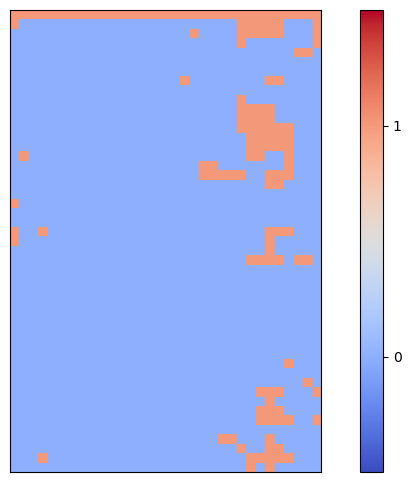

In [175]:
def kewley(niiha):
    return 0.61 / (niiha - 0.05) + 1.3


for object_name in object_names:
    data[object_name]["kewley"] = np.where(
        data[object_name]["oiiihb"] > kewley(data[object_name]["niiha"]), 1, 0
    )

plt.figure(figsize=(10, 6))
plt.imshow(data["eRO-QPE2"]["kewley"], cmap="coolwarm", interpolation="none")
plt.colorbar(ticks=[0, 1])
plt.clim(-0.5, 1.5)
plt.xticks([])
plt.yticks([])
plt.show()

/tmp/ipykernel_1433323/2506362210.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("viridis", len(object_names))


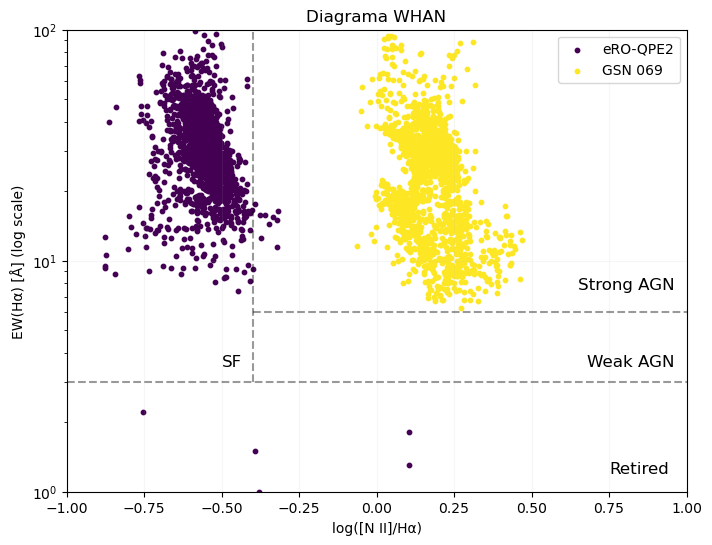

In [176]:
plt.figure(figsize=(8, 6))

cmap = plt.cm.get_cmap("viridis", len(object_names))
ax = plt.gca()

for i, object_name in enumerate(object_names):
    ax.scatter(
        data[object_name]["niiha"],
        data[object_name]["WHa"],
        s=10,
        label=object_name,
        color=cmap(i),
    )

plt.hlines(y=6, xmin=-0.4, xmax=1, color="black", linestyle="--", alpha=0.4)
plt.hlines(y=3, xmin=-1, xmax=1, color="black", linestyle="--", alpha=0.4)
plt.vlines(x=-0.4, ymin=3, ymax=100, color="black", linestyle="--", alpha=0.4)

plt.text(-0.5, 3.5, "SF", fontsize=12)
plt.text(0.65, 7.5, "Strong AGN", fontsize=12)
plt.text(0.68, 3.5, "Weak AGN", fontsize=12)
plt.text(0.75, 1.2, "Retired", fontsize=12)

ax.set_title("Diagrama WHAN")
ax.set_xlabel("log([N II]/Hα)")
ax.set_ylabel("EW(Hα) [Å] (log scale)")
ax.set_xlim(-1, 1)
ax.set_ylim(1, 100)
ax.set_yscale("log")
ax.legend()
ax.grid(alpha=0.1)

plt.show()